In [ ]:
import csv
import pandas as pd

In [ ]:
especies=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/MeIA- Deteccion de Anomalias - Semana 3/codon_usage.csv',sep='\t')
especies = especies.iloc[:, :-1]
#print(especies.head(5))

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(especies)
#X_scaled=especies
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

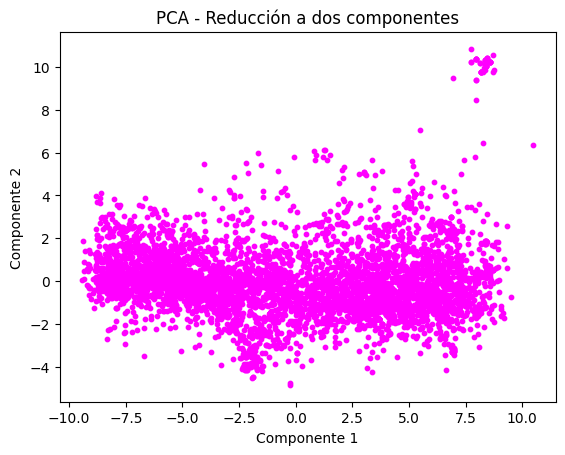

In [ ]:
df_pca = pd.DataFrame(data=X_pca, columns=['Componente 1', 'Componente 2'], index=especies.index)
plt.scatter(df_pca['Componente 1'], df_pca['Componente 2'], s=10, c='fuchsia')

plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('PCA - Reducción a dos componentes')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np

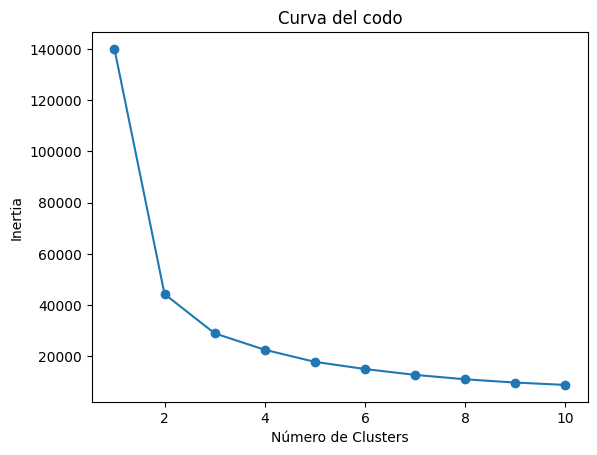

In [ ]:
def curva_codo(data, max_clusters):
    inertia = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    # grafica para la curva del codo
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inertia')
    plt.title('Curva del codo')
    plt.show()

curva_codo(X_pca, 10)

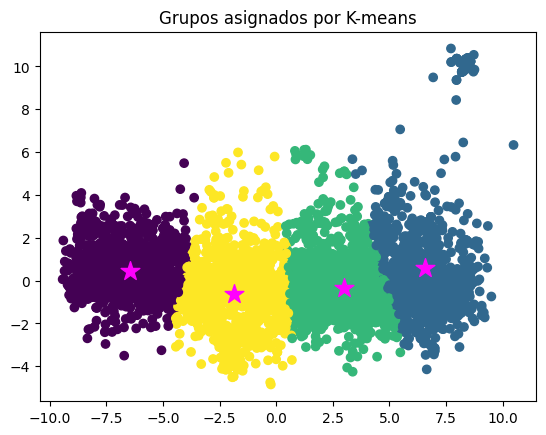

In [ ]:
# Ajustar el modelo K-means con 3 clusters
kmeans = KMeans(n_clusters=4,n_init=10)
kmeans.fit(X_pca)
grupos=kmeans.labels_
centroides = kmeans.cluster_centers_

# Graficar
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=grupos, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], marker='*', s=200, c='fuchsia')
plt.title('Grupos asignados por K-means')
plt.show()

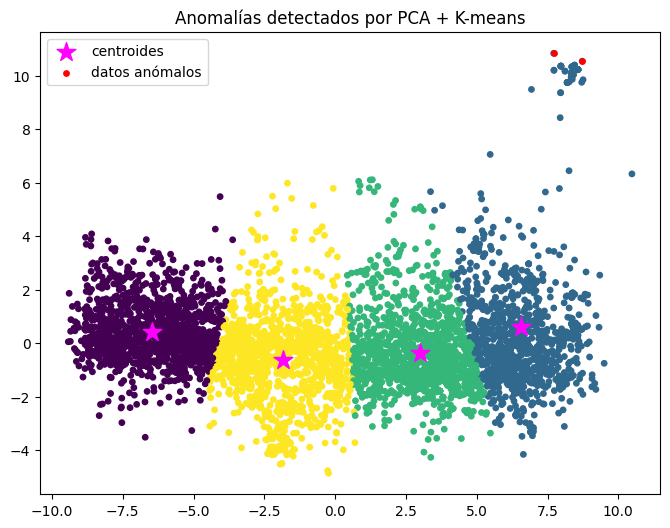

In [ ]:
# Calcular las distancias entre los puntos y los centroides
distancias = cdist(X_pca, centroides, 'euclidean')
distancias = np.min(distancias, axis=1)
umbral = 10
puntos_anomalos = X_pca[distancias > umbral]
#print(puntos_anomalos)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=grupos, cmap='viridis',s=15)
ax.scatter(centroides[:, 0], centroides[:, 1], marker='*', s=200, color='fuchsia',label='centroides')
ax.scatter(puntos_anomalos[:,0], puntos_anomalos[:,1], color='red',label='datos anómalos',s=15)
plt.title('Anomalías detectados por PCA + K-means')
plt.legend()
plt.show()


In [ ]:
indices_anomalos = np.where(distancias > umbral)[0]
especies_anomalas = especies.index[indices_anomalos]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_PCA_Kmeans.txt', especies_anomalas, fmt='%s')

print("Especies con valores anómalos:")
print(especies_anomalas)

Especies con valores anómalos:
Int64Index([955, 962], dtype='int64')


In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
k = 150  # Número de vecinos más cercanos
vecinos_cercanos = NearestNeighbors(n_neighbors=k+1).fit(X_pca)
distancias, indices = vecinos_cercanos.kneighbors(X_pca)

umbral = 8  # Valor de umbral para considerar un punto como anomalía

indices_anomalos = np.where(distancias[:, k] > umbral)[0]
especies_anomalas = especies.index[indices_anomalos]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_PCA_NearestNeighbors.txt', especies_anomalas, fmt='%s')

# Imprimir los índices de los puntos anómalos
print("Índices de los puntos anómalos:")
print(especies_anomalas)



Índices de los puntos anómalos:
Int64Index([ 909,  911,  913,  914,  931,  932,  933,  935,  949,  952,  955,
             956,  957,  958,  959,  960,  962, 2955, 3843],
           dtype='int64')


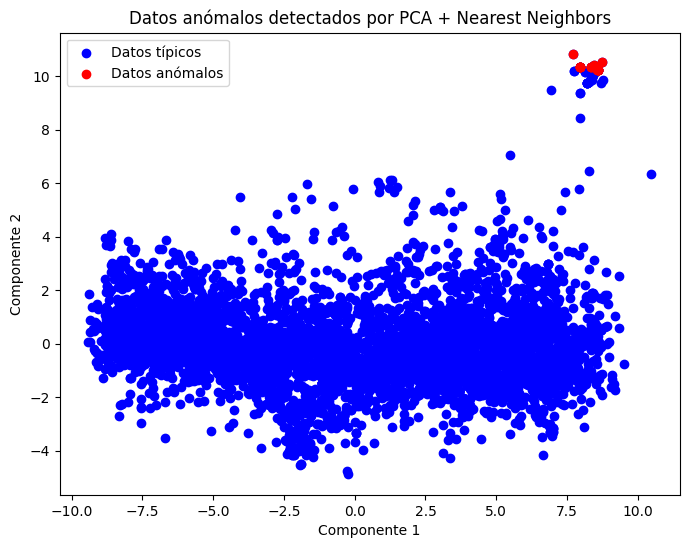

In [ ]:
# Graficar los datos anómalos
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='blue', label='Datos típicos')
plt.scatter(X_pca[indices_anomalos, 0], X_pca[indices_anomalos, 1], color='red', label='Datos anómalos')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Datos anómalos detectados por PCA + Nearest Neighbors')
plt.legend()
plt.show()


In [ ]:
from sklearn.ensemble import IsolationForest

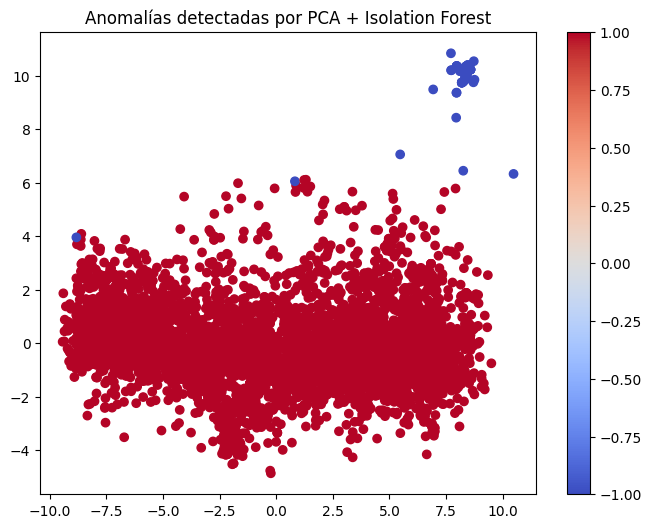

In [ ]:
# Aplicación de Isolation Forest
isolation_forest = IsolationForest(n_estimators=150, contamination=0.01, random_state=42)
isolation_forest.fit(X_pca)
anomaly_labels = isolation_forest.predict(X_pca)

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=anomaly_labels, cmap='coolwarm')
plt.title('Anomalías detectadas por PCA + Isolation Forest')
plt.colorbar()
plt.show()


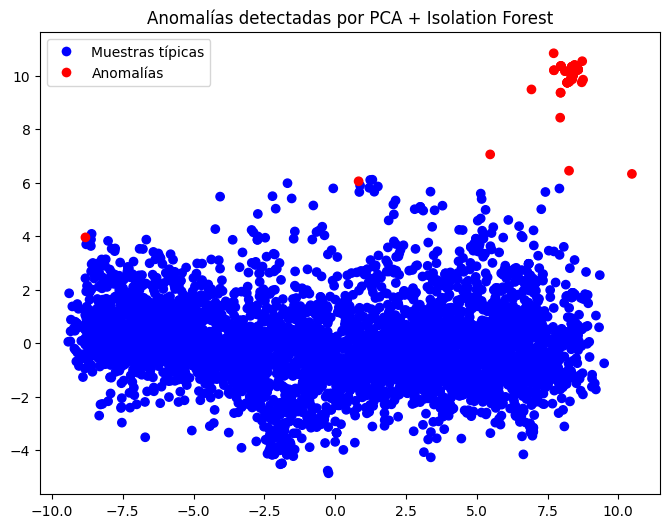

In [ ]:
plt.figure(figsize=(8, 6))
# Colores personalizados
colors = np.array(['blue' if label == 1 else 'red' for label in anomaly_labels])

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors)
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8)],
           labels=['Muestras típicas', 'Anomalías'])

plt.title('Anomalías detectadas por PCA + Isolation Forest')
plt.show()


In [ ]:
indices_anomalos = np.where(anomaly_labels == -1)[0]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_PCA_Isolation Forest.txt', indices_anomalos, fmt='%s')

# Imprimir los índices de las anomalías
print("Índices de las anomalías:")
print(indices_anomalos)

Índices de las anomalías:
[ 327  328  909  911  913  914  917  922  923  925  926  928  929  931
  932  933  935  936  938  939  940  941  942  943  944  945  946  947
  949  952  955  956  957  958  959  960  962  963  967 1383 1818 2289
 2357 2911 2955 2956 3843 4288 4339 4712]


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(especies)
#X_scaled=especies

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

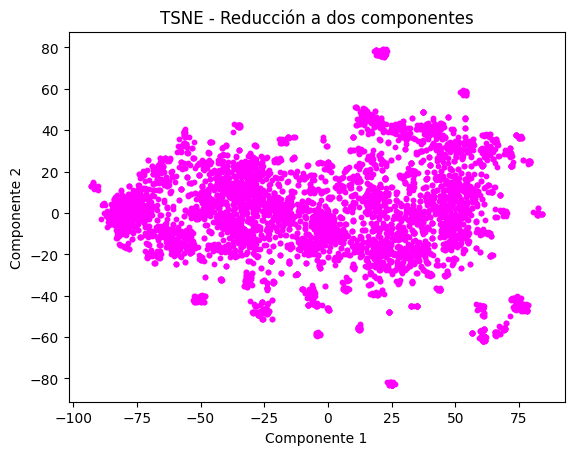

In [ ]:
df_tsne = pd.DataFrame(data=X_tsne, columns=['Componente 1', 'Componente 2'], index=especies.index)
plt.scatter(df_tsne['Componente 1'], df_tsne['Componente 2'], s=10, c='fuchsia')

plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('TSNE - Reducción a dos componentes')
plt.show()

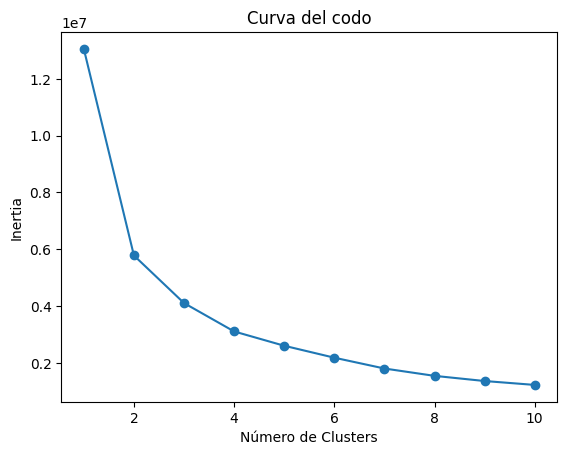

In [ ]:
def curva_codo(data, max_clusters):
    inertia = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    # grafica para la curva del codo
    plt.plot(range(1, max_clusters + 1), inertia, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inertia')
    plt.title('Curva del codo')
    plt.show()

curva_codo(X_tsne, 10)

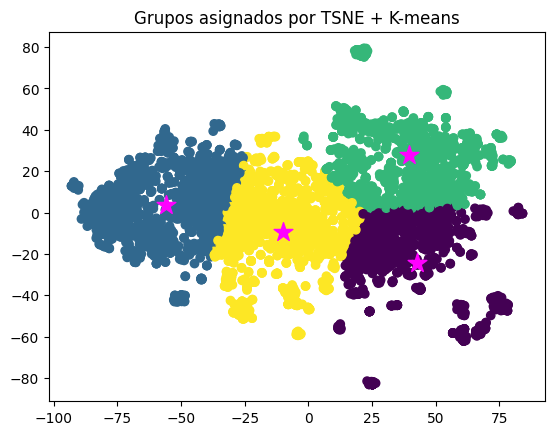

In [ ]:
# Ajustar el modelo K-means con 3 clusters
kmeans = KMeans(n_clusters=4,n_init=10)
kmeans.fit(X_tsne)
grupos=kmeans.labels_
centroides = kmeans.cluster_centers_

# Graficar
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=grupos, cmap='viridis')
plt.scatter(centroides[:, 0], centroides[:, 1], marker='*', s=200, c='fuchsia')
plt.title('Grupos asignados por TSNE + K-means')
plt.show()

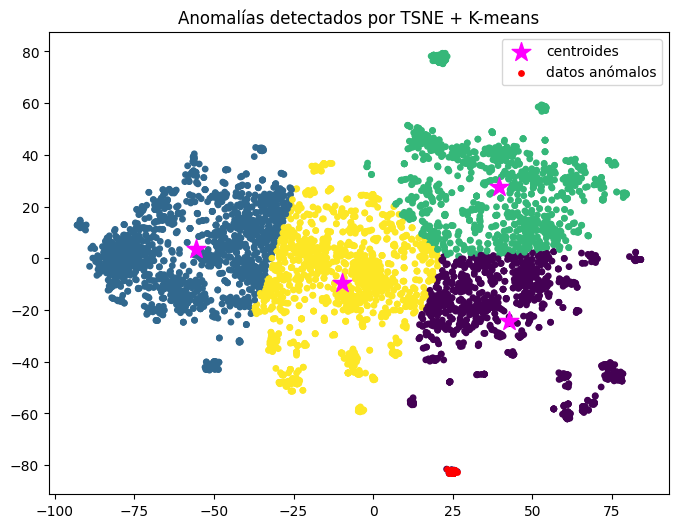

In [ ]:
# Calcular las distancias entre los puntos y los centroides
distancias = cdist(X_tsne, centroides, 'euclidean')
distancias = np.min(distancias, axis=1)
umbral = 57
puntos_anomalos = X_tsne[distancias > umbral]
#print(puntos_anomalos)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis',s=15)
ax.scatter(centroides[:, 0], centroides[:, 1], marker='*', s=200, color='fuchsia',label='centroides')
ax.scatter(puntos_anomalos[:,0], puntos_anomalos[:,1], color='red',label='datos anómalos',s=15)
plt.title('Anomalías detectados por TSNE + K-means')
plt.legend()
plt.show()

In [ ]:
indices_anomalos = np.where(distancias > umbral)[0]
especies_anomalas = especies.index[indices_anomalos]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_TSNE_Kmeans.txt', especies_anomalas, fmt='%s')

print("Especies con valores anómalos:")
print(especies_anomalas)

Especies con valores anómalos:
Int64Index([ 762, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775,
            3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786,
            3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 4292],
           dtype='int64')


In [ ]:
k = 75  # Número de vecinos más cercanos
vecinos_cercanos = NearestNeighbors(n_neighbors=k+1).fit(X_tsne)
distancias, indices = vecinos_cercanos.kneighbors(X_tsne)

umbral = 40  # Valor de umbral para considerar un punto como anomalía

indices_anomalos = np.where(distancias[:, k] > umbral)[0]
especies_anomalas = especies.index[indices_anomalos]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_TSNE_NearestNeighbors.txt', especies_anomalas, fmt='%s')

# Imprimir los índices de los puntos anómalos
print("Índices de los puntos anómalos:")
print(especies_anomalas)


Índices de los puntos anómalos:
Int64Index([], dtype='int64')


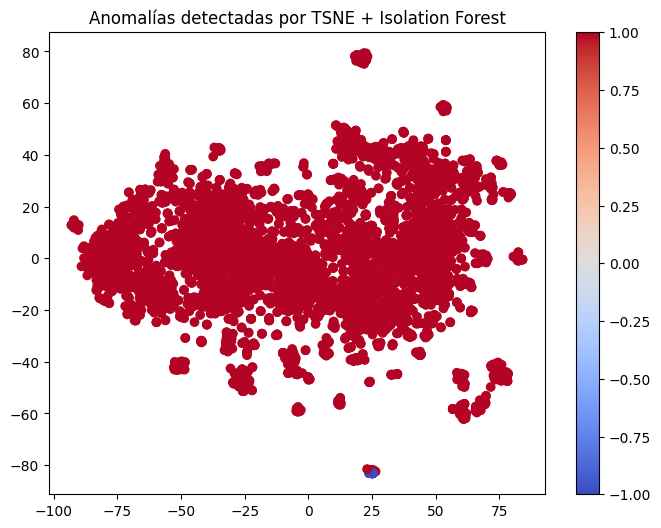

In [ ]:
# Aplicación de Isolation Forest
isolation_forest = IsolationForest(n_estimators=500, contamination=0.01, random_state=42)
isolation_forest.fit(X_tsne)
anomaly_labels = isolation_forest.predict(X_tsne)

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=anomaly_labels, cmap='coolwarm')
plt.title('Anomalías detectadas por TSNE + Isolation Forest')
plt.colorbar()
plt.show()

In [ ]:
indices_anomalos = np.where(anomaly_labels == -1)[0]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_TSNE_Isolation Forest.txt', indices_anomalos, fmt='%s')

# Imprimir los índices de las anomalías
print("Índices de las anomalías:")
print(indices_anomalos)

Índices de las anomalías:
[3766 3769 3771 3772 3773 3774 3775 3776 3777 3778 3779 3781 3782 3783
 3785 3786 3787 3788 3789 3790 3791 3792 3793 3794 3795]


In [ ]:
from sklearn.manifold import Isomap

In [ ]:
n_components = 2  # Número de dimensiones a las que se reducirán los datos
isomap = Isomap(n_components=n_components)
datos=especies
isomap.fit(datos)
X_ism = isomap.transform(datos)


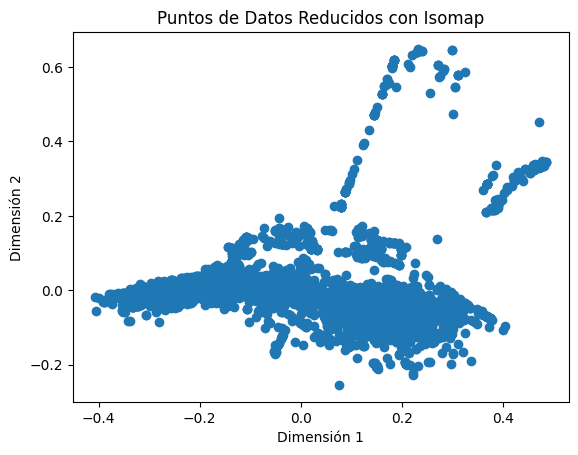

In [ ]:
# Graficar los puntos de datos reducidos
plt.scatter(X_ism[:, 0], X_ism[:, 1])
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')
plt.title('Puntos de Datos Reducidos con Isomap')
plt.show()


In [ ]:
k = 80  # Número de vecinos más cercanos
vecinos_cercanos = NearestNeighbors(n_neighbors=k+1).fit(X_ism)
distancias, indices = vecinos_cercanos.kneighbors(X_ism)
umbral = 0.32  # Valor de umbral para considerar un punto como anomalía

indices_anomalos = np.where(distancias[:, k] > umbral)[0]
especies_anomalas = especies.index[indices_anomalos]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_Isomap_NearestNeighbors.txt', especies_anomalas, fmt='%s')

# Imprimir los índices de los puntos anómalos
print("Índices de los puntos anómalos:")
print(especies_anomalas)

Índices de los puntos anómalos:
Int64Index([ 390,  397,  402,  404, 1884, 1887, 1888, 1889, 1890, 1891, 1892,
            1903, 1957, 1958, 1966, 1967, 1968, 1969, 1970, 1971, 2215, 2217,
            2225, 2226, 2228, 2229, 2281, 2282, 3953, 4762, 4763],
           dtype='int64')


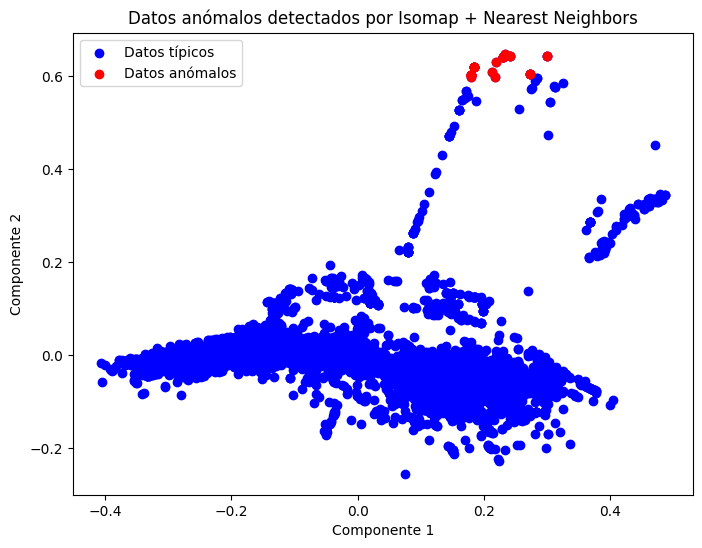

In [ ]:
# Graficar los datos anómalos
plt.figure(figsize=(8, 6))
plt.scatter(X_ism[:, 0], X_ism[:, 1], color='blue', label='Datos típicos')
plt.scatter(X_ism[indices_anomalos, 0], X_ism[indices_anomalos, 1], color='red', label='Datos anómalos')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Datos anómalos detectados por Isomap + Nearest Neighbors')
plt.legend()
plt.show()

Índices de las anomalías:
[ 392  395  399 1883 1893 1950 1957 1958 1974 3054 3056 3066 3070 3071
 3126 3130 3131 3132 3133 3134 3138 3143 3149 3151]


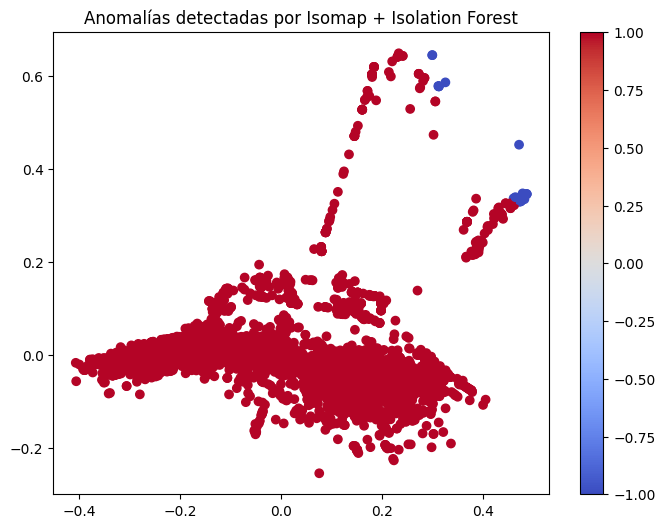

In [ ]:
# Aplicación de Isolation Forest
isolation_forest = IsolationForest(n_estimators=150, contamination=0.005, random_state=42)
isolation_forest.fit(X_ism)
anomaly_labels = isolation_forest.predict(X_ism)

indices_anomalos = np.where(anomaly_labels == -1)[0]

# Guardar los nombres de especies en un archivo de texto
np.savetxt('especies_anomalas_by_Isomap_Isolation Forest.txt', indices_anomalos, fmt='%s')

# Imprimir los índices de las anomalías
print("Índices de las anomalías:")
print(indices_anomalos)



# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_ism[:, 0], X_ism[:, 1], c=anomaly_labels, cmap='coolwarm')
plt.title('Anomalías detectadas por Isomap + Isolation Forest')
plt.colorbar()
plt.show()